In [57]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [58]:
actions = [
    'clenching',
    'away',
    'come'
]

data = np.concatenate([
    np.load('data/seq_clenching.npy'),
    np.load('data/seq_away.npy'),
    np.load('data/seq_come.npy'),
], axis=0)

data.shape

(632, 30, 100)

In [59]:
labelPath = 'data/labels.txt'
dataPath = 'data'

In [60]:
from service import train

with open(labelPath, 'r') as f:
    lines = f.readlines()
    data = np.concatenate([
        np.load(f'{dataPath}/seq_{line.strip().split()[0]}.npy') for line in lines
    ], axis=0)
    actions = [line.strip().split()[1] for line in lines]

data.shape, actions

((632, 30, 100), ['0', '1', '2'])

In [61]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

x_data.shape, labels.shape
labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [62]:
from keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))

y_data.shape
y_data

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [63]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2022)

print(x_train.shape, y_train.shape)

(568, 30, 99) (568, 3)


In [64]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                41984     
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 16)                528       
                                                                 
 dense_16 (Dense)            (None, 3)                 51        
                                                                 
Total params: 44,643
Trainable params: 44,643
Non-trainable params: 0
_________________________________________________________________


In [65]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import EarlyStopping

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/base_model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto'),
    ]
)

Epoch 1/200
16/18 [=========================>....] - ETA: 0s - loss: 37.4284 - acc: 0.4121
Epoch 1: val_acc improved from -inf to 0.42188, saving model to models\base_model.h5
18/18 [==============================] - 1s 19ms/step - loss: 35.2461 - acc: 0.4208 - val_loss: 18.1035 - val_acc: 0.4219 - lr: 0.0010
Epoch 2/200
16/18 [=========================>....] - ETA: 0s - loss: 11.1548 - acc: 0.5078
Epoch 2: val_acc improved from 0.42188 to 0.51562, saving model to models\base_model.h5
18/18 [==============================] - 0s 10ms/step - loss: 10.8684 - acc: 0.5106 - val_loss: 9.0673 - val_acc: 0.5156 - lr: 0.0010
Epoch 3/200
16/18 [=========================>....] - ETA: 0s - loss: 8.8142 - acc: 0.5801
Epoch 3: val_acc improved from 0.51562 to 0.59375, saving model to models\base_model.h5
18/18 [==============================] - 0s 10ms/step - loss: 8.4195 - acc: 0.5898 - val_loss: 18.0024 - val_acc: 0.5938 - lr: 0.0010
Epoch 4/200
17/18 [===========================>..] - ETA: 0s - l

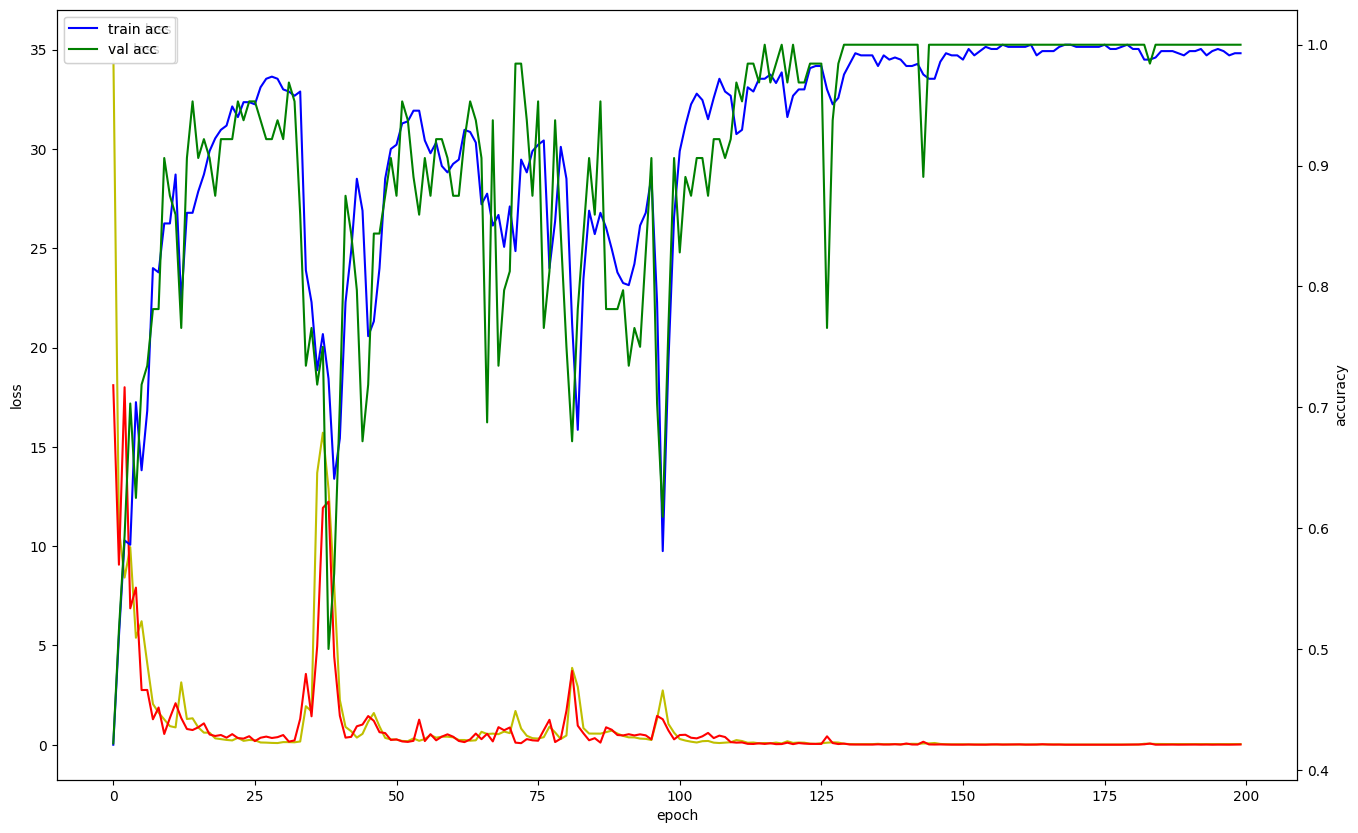

In [66]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()